# Digital Earth Australia Intertidal workflow

## Getting started
Set working directory to top level of repo to ensure links work correctly:

In [1]:
cd ..

/home/jovyan/Robbi/dea-intertidal


Install additional packages directly from the requirements file

In [ ]:
pip install -r requirements.in --quiet

### Load packages

In [2]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd
from ipyleaflet import basemaps, basemap_to_tiles

import datacube
import odc.geo.xr
from odc.geo.geom import Geometry
from odc.ui import select_on_a_map
import cmocean

from dea_tools.dask import create_local_dask_cluster
from dea_tools.coastal import pixel_tides

from intertidal.utils import (
    round_date_strings,
    intertidal_hillshade,
)
from intertidal.io import (
    load_data,
    load_topobathy_mask,
    load_aclum_mask,
    prepare_for_export,
)
from intertidal.elevation import elevation
from intertidal.extents import extents, load_connectivity_mask
from intertidal.exposure import exposure
from intertidal.tidal_bias_offset import bias_offset



## Setup


### Set analysis parameters

In [3]:
# Intertidal Elevation variables
start_date = "2020"  # Start date for analysis
end_date = "2022"  # End date for analysis
resolution = 10  # Spatial resolution used for output files
crs = "EPSG:3577"  # Coordinate Reference System (CRS) to use for output files
ndwi_thresh = 0.1  # Threshold used to identify dry/wet transition
include_s2 = True  # Include Sentinel-2 data in the analysis?
include_ls = True  # Include Landsat data in the analysis?
filter_gqa = True  # Filter to remove poorly georeferenced scenes?
tide_model = "ensemble"  # Tide model to use in analysis
tide_model_dir = "/gdata1/data/tide_models_clipped"

# Exposure variables
modelled_freq = "3h"  # Frequency to run tidal model e.g '30min' or '1h'
filters = None  # Exposure filters eg None, ['Dry', 'Neap_low']
filters_combined = None  # Must be a list of tuples containing one temporal and spatial filter each, eg None or [('Einter','Lowtide')]

##### Option 1: load study area from 32 km tile GridSpec

In [4]:
# # Set study area (e.g. tile ID in form "x094y145")
# study_area = "x094y145"
# geom = None  # Use GridSpec to load study area, not a custom geom

##### Option 2: load study area from vector file

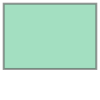

In [5]:
# Set study area to load from file
study_area = "pointstuart"

# Read file, select study area and convert to geom
studyarea_gdf = gpd.read_file(
    "data/raw/intertidal_development_polygons.geojson"
).set_index("id")
geom = Geometry(studyarea_gdf.loc[study_area].geometry, crs=studyarea_gdf.crs)
geom

##### Option 3: load study area using interactive map

In [6]:
# # Set study area name for outputs
# study_area = "testing"

# # Plot interactive map to select area
# basemap = basemap_to_tiles(basemaps.Esri.WorldImagery)
# geom = select_on_a_map(height="600px", layers=(basemap,), center=(-26, 135), zoom=4)
# geom

## Intertidal workflow

### Load data

In [7]:
%%time

# Connect to datacube
dc = datacube.Datacube(app="Intertidal_workflow")

# Create local dask cluster to improve data load time
client = create_local_dask_cluster(return_client=True)

satellite_ds, _, _ = load_data(
    dc=dc,
    study_area=study_area,
    geom=geom,
    time_range=(start_date, end_date),
    resolution=resolution,
    crs=crs,
    include_s2=True,
    include_ls=True,
    filter_gqa=filter_gqa,
    max_cloudcover=90,
    skip_broken_datasets=True,
)

print(satellite_ds)

# Load data
satellite_ds.load()


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,Workers: 1
Total threads: 31,Total memory: 237.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34041,Workers: 1
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,Total threads: 31
Started: Just now,Total memory: 237.21 GiB
Comm: tcp://127.0.0.1:46071,Total threads: 31
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/38613/status,Memory: 237.21 GiB
Nanny: tcp://127.0.0.1:44147,


<xarray.Dataset> Size: 76MB
Dimensions:      (time: 272, y: 219, x: 317)
Coordinates:
  * time         (time) datetime64[ns] 2kB 2020-01-02T00:57:27.736492 ... 202...
  * y            (y) float64 2kB -1.286e+06 -1.286e+06 ... -1.288e+06 -1.288e+06
  * x            (x) float64 3kB -1.404e+04 -1.404e+04 ... -1.09e+04 -1.088e+04
    spatial_ref  int32 4B 3577
Data variables:
    ndwi         (time, y, x) float32 76MB dask.array<chunksize=(1, 219, 317), meta=np.ndarray>
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref


/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


CPU times: user 5.57 s, sys: 367 ms, total: 5.94 s
Wall time: 56 s


<xarray.Dataset> Size: 76MB
Dimensions:      (time: 272, y: 219, x: 317)
Coordinates:
  * time         (time) datetime64[ns] 2kB 2020-01-02T00:57:27.736492 ... 202...
  * y            (y) float64 2kB -1.286e+06 -1.286e+06 ... -1.288e+06 -1.288e+06
  * x            (x) float64 3kB -1.404e+04 -1.404e+04 ... -1.09e+04 -1.088e+04
    spatial_ref  int32 4B 3577
Data variables:
    ndwi         (time, y, x) float32 76MB nan nan nan nan ... nan nan nan nan
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [8]:
# Model tides spatially using `pixel_tides`
tides_lowres = pixel_tides(satellite_ds, resample=False)

Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides using FES2014 in parallel


100%|██████████| 5/5 [00:06<00:00,  1.37s/it]


Returning low resolution tide array


### Load optional masks
Loads a topo-bathymetric DEM for the extents of the loaded satellite data.
This is used as a coarse mask to constrain the analysis to the coastal zone, improving run time and reducing clear false positives over deep water or elevated land.

In [9]:
# Load data from GA's AusBathyTopo 250m 2023 Grid
topobathy_mask = load_topobathy_mask(
    dc=dc,
    geobox=satellite_ds.odc.geobox,
    product="ga_ausbathytopo250m_2023",
    resampling="bilinear",
    min_threshold=-15,
    mask_filters=[("dilation", 25)],
)

Generate a coastal mask, based on the connectivity of each pixel to the ocean. Coastal pixels are identified by calculating "least-cost" distances from ocean weighted by elevation, where low, flat areas of terrain are assigned lower weights than high, steep pixels. This produces a coastal mask that extends further inland in low-lying coastal areas.

In [10]:
# Generate coastal connectivity mask to exclude non-tidal areas
coastal_mask, _ = load_connectivity_mask(
    dc=dc,
    geobox=satellite_ds.odc.geobox,
    product='ga_srtm_dem1sv1_0',
    elevation_band='dem_h',
    resampling='bilinear',
    buffer=20000,
    max_threshold=100,
)

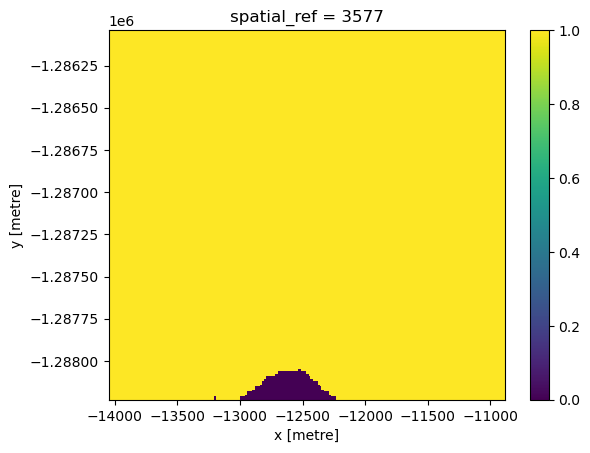

In [11]:
# Combined mask
combined_mask = (topobathy_mask & coastal_mask)
combined_mask.plot()

### Intertidal elevation
To run without the topobathy DEM mask, comment out `valid_mask=...`.

In [12]:
# Model elevation for each pixel
ds, tide_m = elevation(
    satellite_ds,
    valid_mask=topobathy_mask,
    tide_model=tide_model,
    tide_model_dir=tide_model_dir,
)

2024-09-20 03:45:23 INFO Processing: Modelling tide heights for each pixel


Creating reduced resolution 5000 x 5000 metre tide modelling array
Running ensemble tide modelling
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 35/35 [00:25<00:00,  1.40it/s]


Interpolating model rankings using IDW interpolation 
Combining models into single ensemble model
Reprojecting tides into original array


2024-09-20 03:45:54 INFO Processing: Masking nodata and adding tide heights to satellite data array
2024-09-20 03:45:54 INFO Processing: Flattening satellite data array and filtering to intertidal candidate pixels
2024-09-20 03:45:54 INFO Processing: Applying valid data mask to constrain study area
2024-09-20 03:45:55 INFO Processing: Running per-pixel rolling median


Reducing analysed pixels from 69423 to 43236 (62.28%)


  0%|          | 0/105 [00:00<?, ?it/s]

2024-09-20 03:46:37 INFO Processing: Modelling intertidal elevation


Applying tidal interval interpolation to 200 intervals
Applying rolling mean smoothing with radius 20


2024-09-20 03:46:38 INFO Processing: Modelling intertidal uncertainty
2024-09-20 03:46:38 INFO Processing: Unflattening data back to its original spatial dimensions
2024-09-20 03:46:38 INFO Processing: Cleaning inaccurate upper intertidal pixels
2024-09-20 03:46:38 INFO Processing: Successfully completed intertidal elevation modelling


### Intertidal extents
Use the outputs of the elevation function to categorically map the intertidal extents.

In [13]:
# Load urban mask used to remove inland false positives
urban_mask = load_aclum_mask(
    dc=dc,
    geobox=satellite_ds.odc.geobox,
)

# Calculate extents
ds["extents"] = extents(
    dem=ds.elevation,
    freq=ds.qa_ndwi_freq,
    corr=ds.qa_ndwi_corr,
    urban_mask=urban_mask,
    coastal_mask=coastal_mask,
)

### Intertidal exposure
Calculate intertidal exposure for each pixel with an intertidal elevation.
To calculate exposure for the full time period, leave `filters` commented out or set as `["unfiltered"]`.
See the function documentation for the full range of available `filters` and `filters_combined`.
The code accepts lists of multiple `filters` and `filter_combined` tuples.

In [ ]:
# Calculate exposure
exposure_filters, modelledtides_ds = exposure(
    dem=ds.elevation,
    start_date=start_date,
    end_date=end_date,
    modelled_freq=modelled_freq,
    tide_model=tide_model,
    tide_model_dir=tide_model_dir,
    filters=filters,
    filters_combined=filters_combined,
)

# Write each exposure output as new variables in the main dataset
for x in exposure_filters.data_vars:
    ds[f"exposure_{x}"] = exposure_filters[x]

### Spread and offset
Calculate the spread and high/low tide biases of input observed images as a percentage of the modelled tide heights.

<div class="alert alert-info">

**Note:** this code will only work if the `exposure` function above has been run and produced 'unfiltered' exposure results.

</div>

In [ ]:
(
    ds["ta_lat"],
    ds["ta_hat"],
    ds["ta_lot"],
    ds["ta_hot"],
    ds["ta_spread"],
    ds["ta_offset_low"],
    ds["ta_offset_high"],
) = bias_offset(
    tide_m=tide_m, tide_cq=modelledtides_ds['unfiltered'], lot_hot=True, lat_hat=True
)

## Plot all layers

In [ ]:
# Inspect contents of ds before plotting
ds

In [ ]:
plt.clf()

fig = plt.figure(figsize=(12, 12), tight_layout=True)
ax_dict = fig.subplot_mosaic(
    """
    AAAABBBBCCCC
    DDDEEEFFFGGG
    HHHIIIJJJKKK
    """,
    height_ratios=[1, 0.8, 0.8],
)

# label_params = dict(add_labels=False, yticks=[], xticks=[])

# Plot Elevation with hillshade
ds["elevation"].plot.imshow(
    ax=ax_dict["A"],
    cmap="viridis",
    interpolation="bilinear",
)
# intertidal_hillshade(ds["elevation"], ds["qa_ndwi_freq"], vert_exag=300).plot.imshow(
#     ax=ax_dict["A"],
#     interpolation="bilinear",
# )
ax_dict["A"].set_title("Elevation (metres AMSL)")

# Plot uncertainty
ds["elevation_uncertainty"].plot.imshow(
    ax=ax_dict["B"],
    cmap="magma",
    interpolation="bilinear",
)
ax_dict["B"].set_title("Elevation uncertainty (metres)")
ax_dict["B"].set_facecolor("#2E2E2E")

# Plot Exposure
ds["exposure_unfiltered"].plot.imshow(
    ax=ax_dict["C"],
    cmap=cmocean.cm.matter_r,
    levels=np.arange(0, 100, 1),
    add_labels=False,
    yticks=[],
)
ax_dict["C"].set_title("Exposure")

# Plot Extents
ds["extents"].astype(np.int16).plot.imshow(ax=ax_dict["D"])
ax_dict["D"].set_title("Extents")

# Plot the observation spread
ds["ta_spread"].where(ds.elevation.notnull()).plot.imshow(
    ax=ax_dict["E"],
    vmin=0,
    vmax=100,
    cmap="magma",
    cbar_kwargs={"label": "% of tidal range observed"},
)
ax_dict["E"].set_title("Observation Spread (%)")

# Plot the high-tide offset
ds["ta_offset_high"].where(ds.elevation.notnull()).plot.imshow(
    ax=ax_dict["F"],
    vmin=0,
    vmax=40,
    cmap="magma",
    cbar_kwargs={"label": "% of high tide never observed"},
)
ax_dict["F"].set_title("High-tide offset (%)")

# Plot the low-tide offset
ds["ta_offset_low"].where(ds.elevation.notnull()).plot.imshow(
    ax=ax_dict["G"],
    vmin=0,
    vmax=40,
    cmap="magma",
    cbar_kwargs={"label": "% of low tide never observed"},
)
ax_dict["G"].set_title("Low-tide offset (%)")

# Plot the LAT
ds["ta_lat"].where(ds.elevation.notnull()).plot.imshow(
    ax=ax_dict["H"],
    vmin=ds["ta_lat"].min(),
    vmax=ds["ta_hat"].max(),
    add_labels=False,
)
ax_dict["H"].set_title("Lowest Astronomical Tide")

# Plot the LOT
ds["ta_lot"].where(ds.elevation.notnull()).plot.imshow(
    ax=ax_dict["I"], vmin=ds["ta_lat"].min(), vmax=ds["ta_hat"].max()
)
ax_dict["I"].set_title("Lowest Observed Tide")

# Plot the HAT
ds["ta_hat"].where(ds.elevation.notnull()).plot.imshow(
    ax=ax_dict["J"],
    vmin=ds["ta_lat"].min(),
    vmax=ds["ta_hat"].max(),
    add_labels=False,
    yticks=[],
)
ax_dict["J"].set_title("Highest Astronomical Tide")

# Plot the HOT
ds["ta_hot"].where(ds.elevation.notnull()).plot.imshow(
    ax=ax_dict["K"],
    vmin=ds["ta_lat"].min(),
    vmax=ds["ta_hat"].max(),
)
ax_dict["K"].set_title("Highest Observed Tide")

# Remove axis labels
for label, ax in ax_dict.items():
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_ylabel("")
    ax.set_xlabel("")

## Export layers

In [ ]:
# Create output folder if it doesn't exist
output_dir = f"data/interim/{study_area}/{start_date}-{end_date}"
os.makedirs(output_dir, exist_ok=True)

# Prepare data for export
ds["qa_ndwi_freq"] *= 100  # Convert frequency to %

# Prepare for export by correctly setting nodata and dtypes, then
# export to file
ds_prepared = prepare_for_export(ds, output_location=output_dir)

In [ ]:
# Export figure
fig.savefig(f"data/interim/{study_area}/{start_date}-{end_date}/outputs.png")

### Close Dask client

In [ ]:
client.close()